# DNSC 6290 Machine Learning Project
## Home Credit Default Risk
#### https://www.kaggle.com/c/home-credit-default-risk/overview
### Group 2
### Group members: Lili Zhang/Yuwei Yao/Jiaqi Ling/Renlu Zhang

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import functools
import lightgbm as lgb
import seaborn as sns 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

## 1. Import data set

In [2]:
path = '/Users/renluzhang/home-credit-default-risk/'

In [3]:
application_train = pd.read_csv(path+'application_train.csv')
application_test = pd.read_csv(path+'application_test.csv')
pos_cash_balance = pd.read_csv(path+'POS_CASH_balance.csv')
bureau = pd.read_csv(path+'bureau.csv')
bureau_balance = pd.read_csv(path+'bureau_balance.csv')
credit_card_balance = pd.read_csv(path+'credit_card_balance.csv')
installments_payments = pd.read_csv(path+'installments_payments.csv')
previous_app = pd.read_csv(path+'previous_application.csv')

In [4]:
# print the size of each data set
print('Size of application_train data', application_train.shape)
print('Size of application_test data', application_test.shape)
print('Size of POS_CASH_balance data', pos_cash_balance.shape)
print('Size of bureau data', bureau.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_app.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau data (1716428, 17)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)


---
## 2. Data exploration & analysis

### Exploring missing values

In [5]:
# Missing value function
def missing_value_df(dataframe):
    missing_df = pd.DataFrame(columns = ['col_name','data_type', 'missing_value', 'missing_percent'])
    missing_df.col_name = dataframe.columns
    missing_df.data_type = [dataframe[c].dtypes for c in dataframe.columns]
    missing_df.missing_value = [dataframe[c].isna().sum() for c in dataframe.columns]
    missing_df.missing_percent = [round(dataframe[c].isna().sum()/len(dataframe),6)*100 for c in dataframe.columns]
    missing_df = missing_df.sort_values(by = 'missing_percent', ascending = False)
    return missing_df

In [6]:
missing_value_df(application_train).head()

,col_name,data_type,missing_value,missing_percent
76,COMMONAREA_MEDI,float64,214865,69.8723
48,COMMONAREA_AVG,float64,214865,69.8723
62,COMMONAREA_MODE,float64,214865,69.8723
70,NONLIVINGAPARTMENTS_MODE,float64,213514,69.4330
56,NONLIVINGAPARTMENTS_AVG,float64,213514,69.4330


In [7]:
missing_value_df(application_test).head()

,col_name,data_type,missing_value,missing_percent
47,COMMONAREA_AVG,float64,33495,68.7161
61,COMMONAREA_MODE,float64,33495,68.7161
75,COMMONAREA_MEDI,float64,33495,68.7161
55,NONLIVINGAPARTMENTS_AVG,float64,33347,68.4125
69,NONLIVINGAPARTMENTS_MODE,float64,33347,68.4125


In [8]:
missing_value_df(pos_cash_balance).head()

,col_name,data_type,missing_value,missing_percent
4,CNT_INSTALMENT_FUTURE,float64,26087,0.2608
3,CNT_INSTALMENT,float64,26071,0.2607
0,SK_ID_PREV,int64,0,0.0000
1,SK_ID_CURR,int64,0,0.0000
2,MONTHS_BALANCE,int64,0,0.0000


In [9]:
missing_value_df(bureau).head()

,col_name,data_type,missing_value,missing_percent
16,AMT_ANNUITY,float64,1226791,71.4735
8,AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.5133
7,DAYS_ENDDATE_FACT,float64,633653,36.9170
12,AMT_CREDIT_SUM_LIMIT,float64,591780,34.4774
11,AMT_CREDIT_SUM_DEBT,float64,257669,15.0119


In [10]:
missing_value_df(bureau_balance).head()

,col_name,data_type,missing_value,missing_percent
0,SK_ID_BUREAU,int64,0,0.0
1,MONTHS_BALANCE,int64,0,0.0
2,STATUS,object,0,0.0


In [11]:
missing_value_df(previous_app).head()

,col_name,data_type,missing_value,missing_percent
14,RATE_INTEREST_PRIVILEGED,float64,1664263,99.6437
13,RATE_INTEREST_PRIMARY,float64,1664263,99.6437
6,AMT_DOWN_PAYMENT,float64,895844,53.6365
12,RATE_DOWN_PAYMENT,float64,895844,53.6365
20,NAME_TYPE_SUITE,object,820405,49.1198


In [12]:
missing_value_df(installments_payments).head()

,col_name,data_type,missing_value,missing_percent
5,DAYS_ENTRY_PAYMENT,float64,2905,0.0214
7,AMT_PAYMENT,float64,2905,0.0214
0,SK_ID_PREV,int64,0,0.0000
1,SK_ID_CURR,int64,0,0.0000
2,NUM_INSTALMENT_VERSION,float64,0,0.0000


In [13]:
missing_value_df(credit_card_balance).head()

,col_name,data_type,missing_value,missing_percent
10,AMT_PAYMENT_CURRENT,float64,767988,19.9981
5,AMT_DRAWINGS_ATM_CURRENT,float64,749816,19.5249
18,CNT_DRAWINGS_POS_CURRENT,float64,749816,19.5249
7,AMT_DRAWINGS_OTHER_CURRENT,float64,749816,19.5249
8,AMT_DRAWINGS_POS_CURRENT,float64,749816,19.5249


### Feature exploring

Text(0.5, 1.0, 'Count of TARGET')

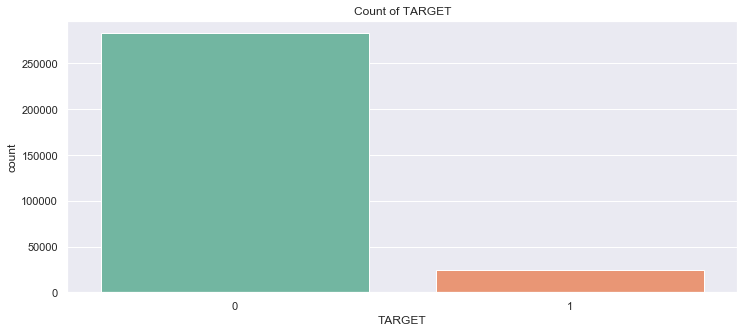

In [15]:
# explore the target
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")
ax = sns.countplot(x= 'TARGET', data=application_train, palette="Set2")
ax.set_title("Count of TARGET")

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


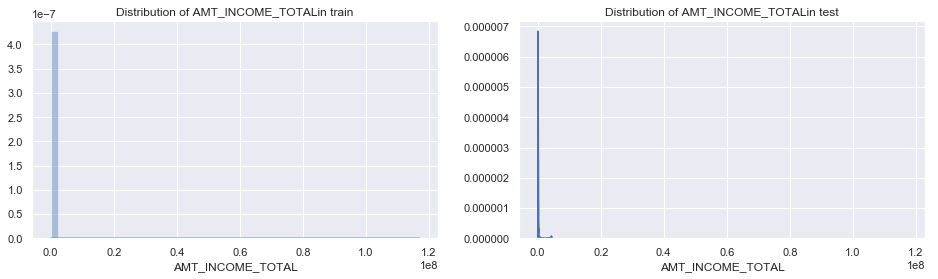

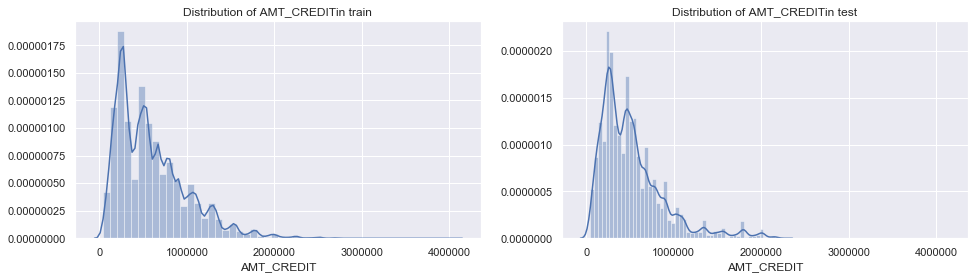

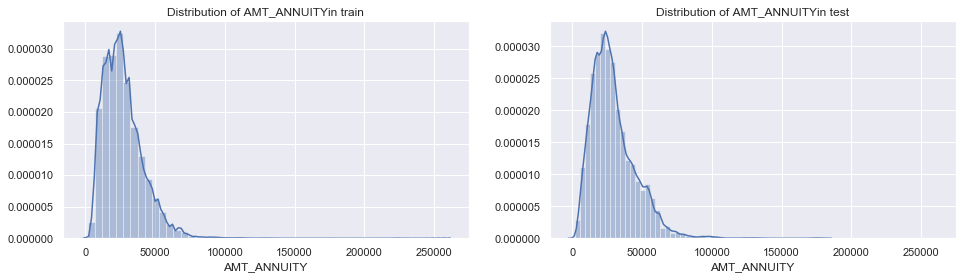

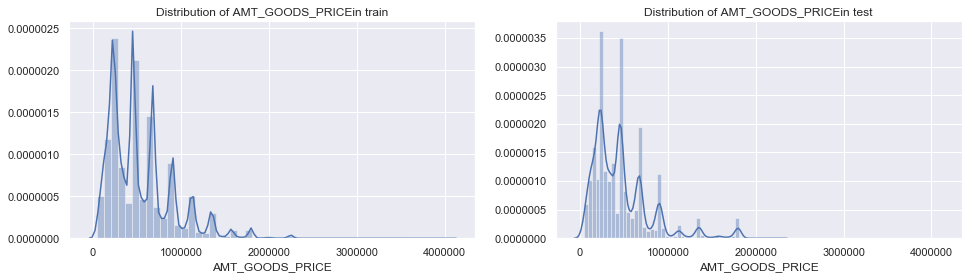

In [16]:
# explore amount numeric variables
amt_var = application_train.select_dtypes('float').columns[0:4]
for var in amt_var:
    f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)
    sns.distplot(application_train[var].dropna(), ax=axes[0])
    sns.distplot(application_test[var].dropna(), ax=axes[1])
    axes[0].set_title("Distribution of " + var + "in train")
    axes[1].set_title("Distribution of " + var + "in test")

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


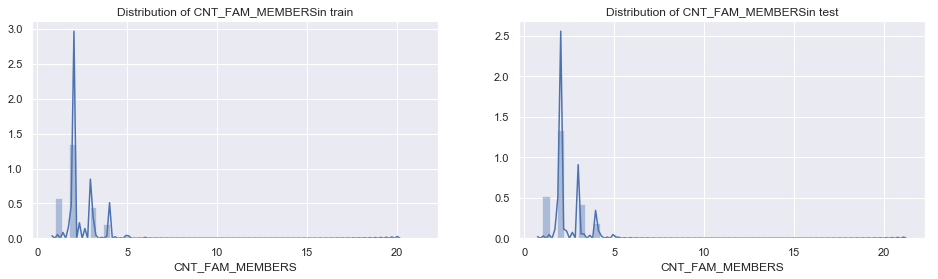

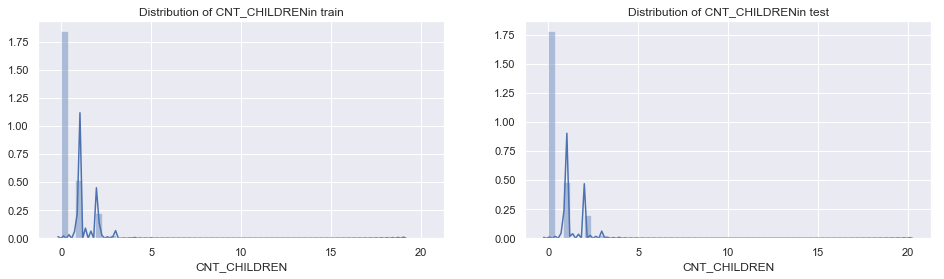

In [17]:
# explore number of children and number of family members
fam_var = ['CNT_FAM_MEMBERS', 'CNT_CHILDREN']
for var in fam_var:
    f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)
    sns.distplot(application_train[var].dropna(), ax=axes[0])
    sns.distplot(application_test[var].dropna(), ax=axes[1])
    axes[0].set_title("Distribution of " + var + "in train")
    axes[1].set_title("Distribution of " + var + "in test")

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


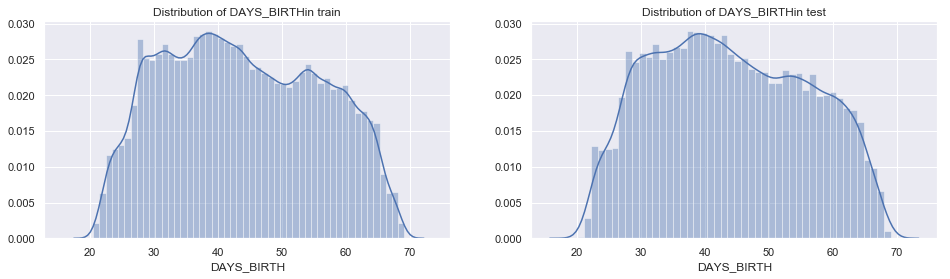

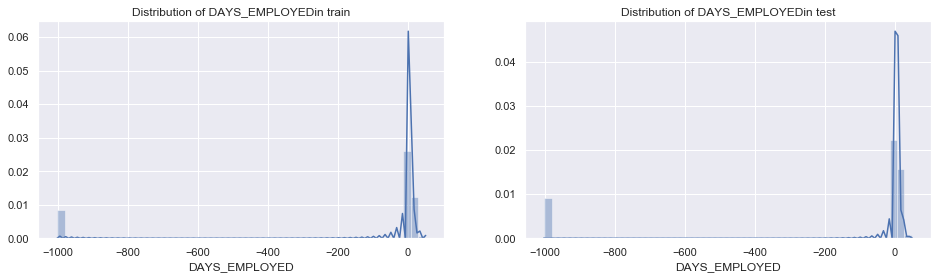

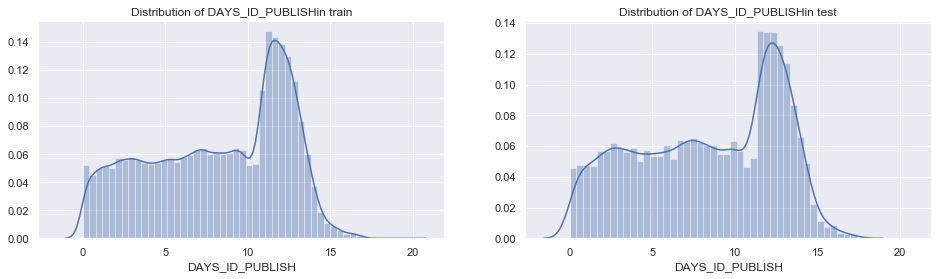

In [18]:
# explore age, employed days and DAYS_ID_PUBLISH
day_var = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']
for var in day_var:
    f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)
    sns.distplot(-application_train[var].dropna()/365, ax=axes[0])
    sns.distplot(-application_test[var].dropna()/365, ax=axes[1])
    axes[0].set_title("Distribution of " + var + "in train")
    axes[1].set_title("Distribution of " + var + "in test")

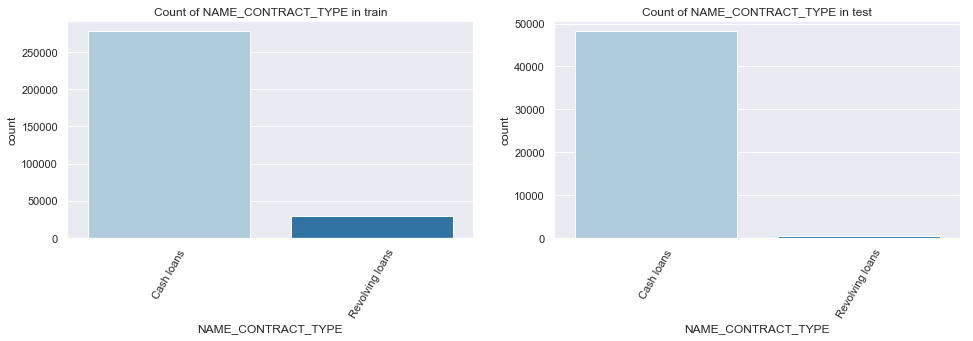

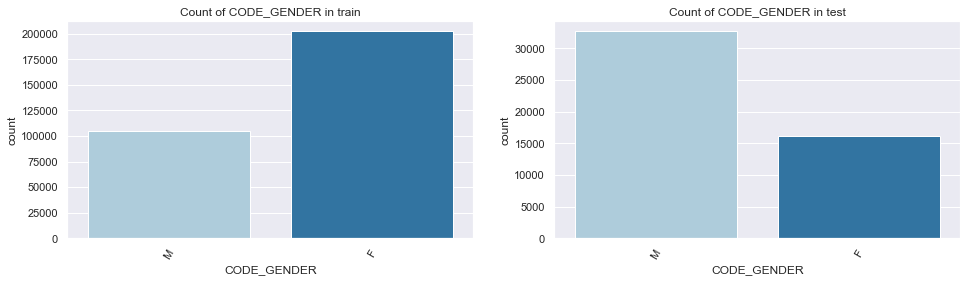

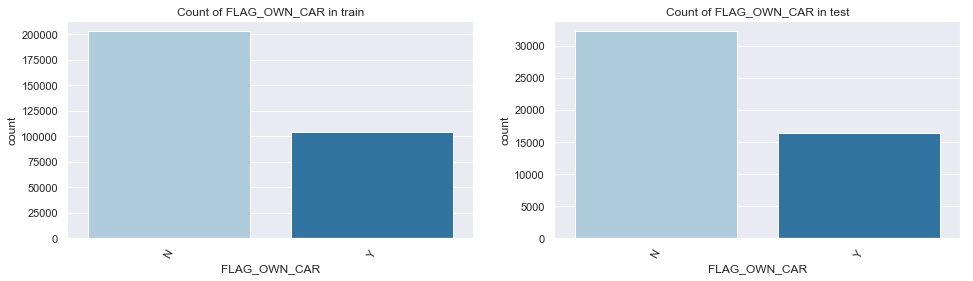

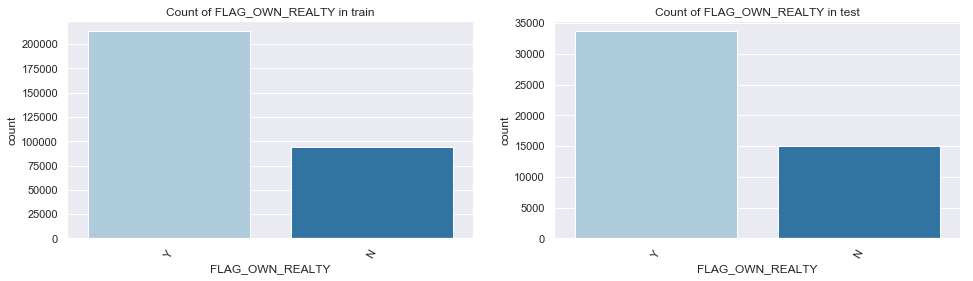

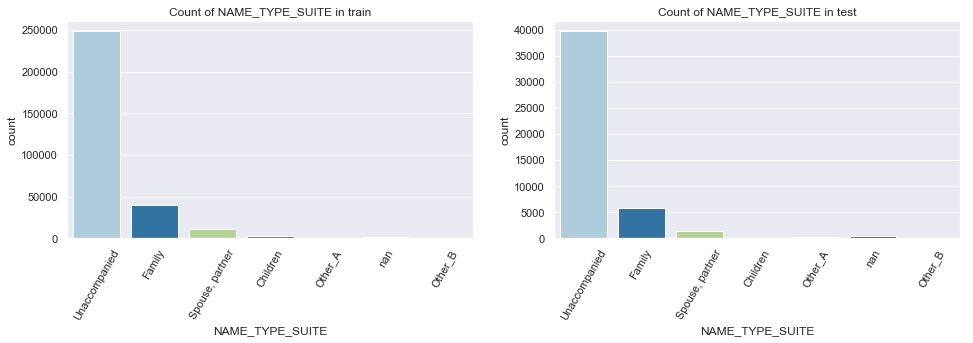

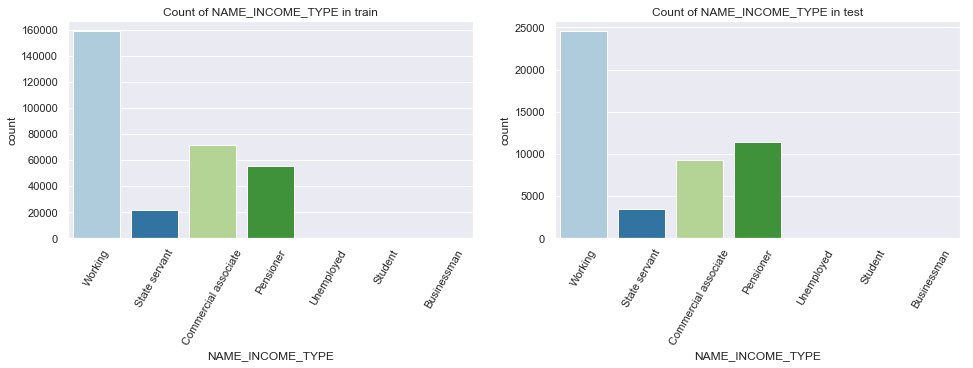

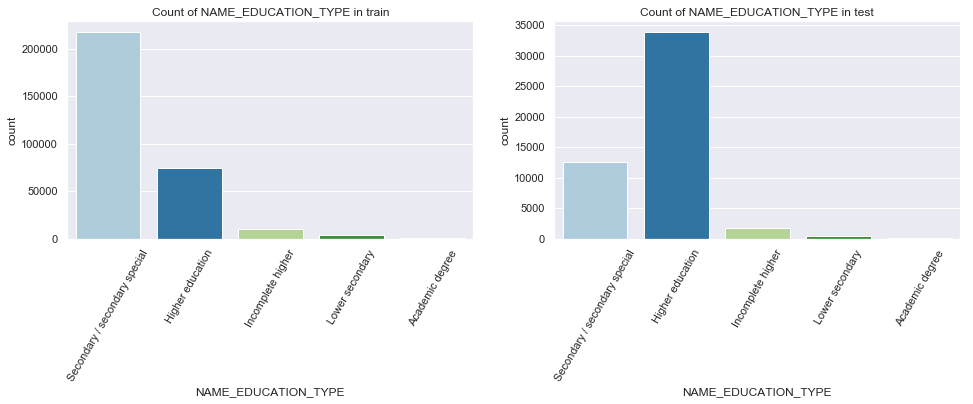

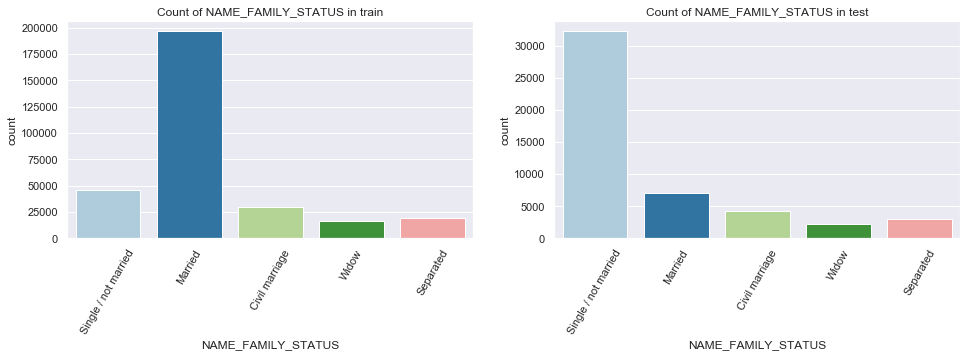

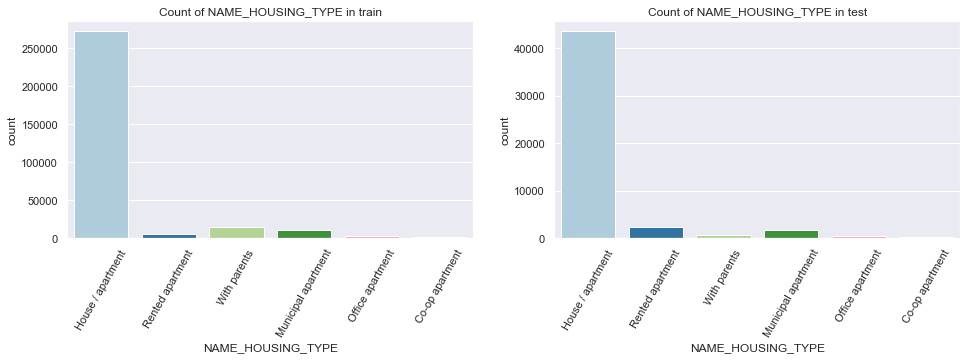

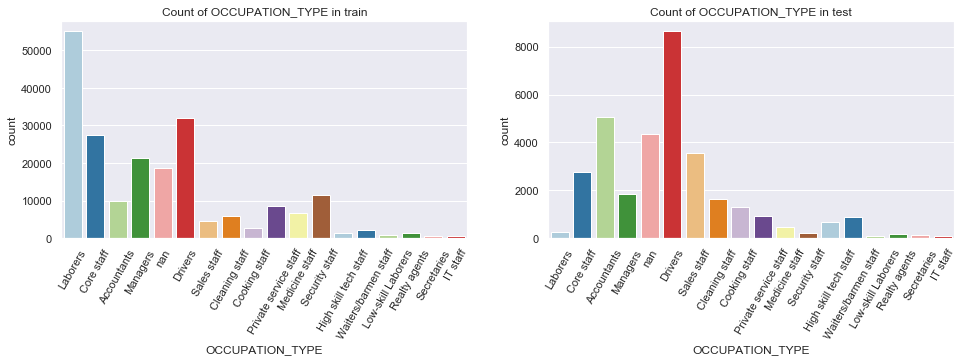

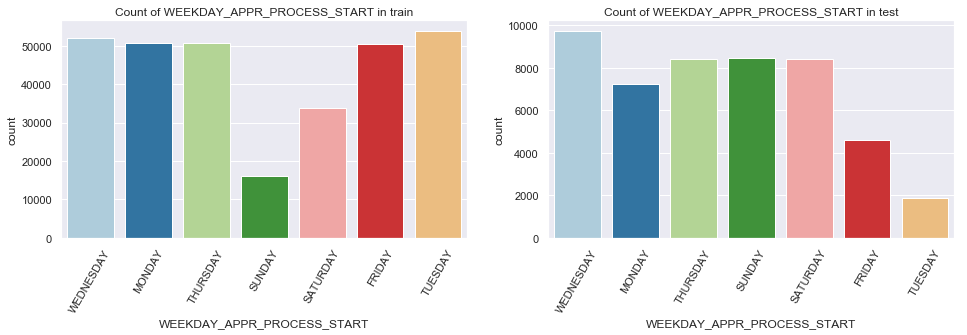

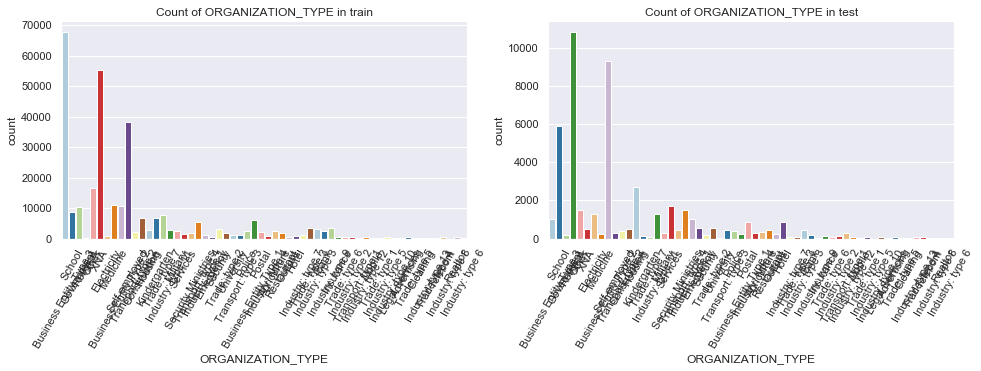

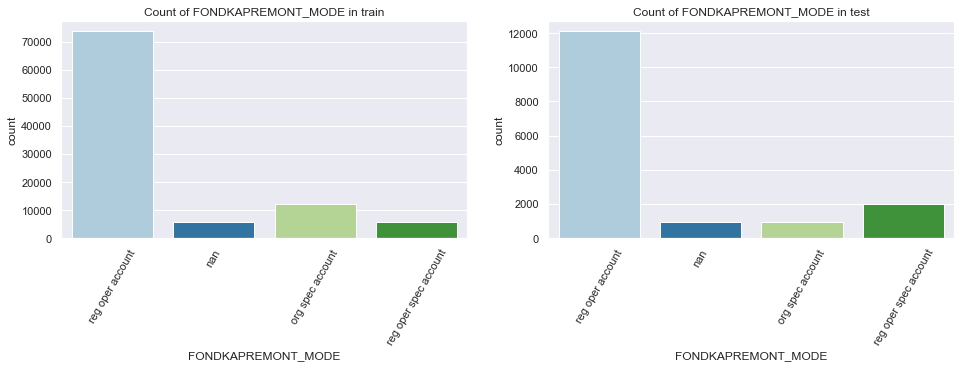

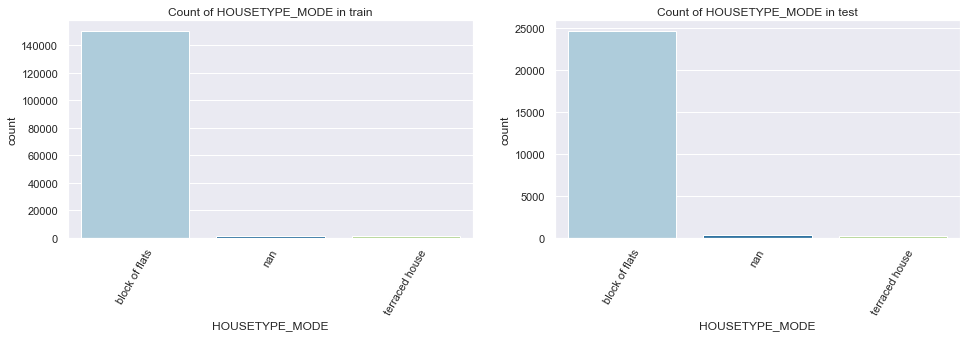

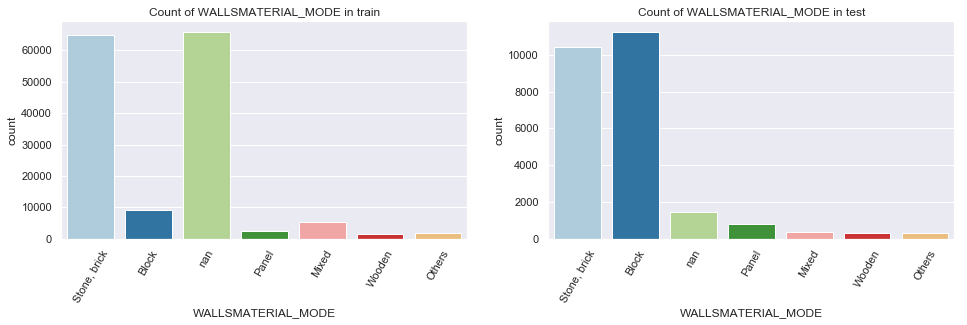

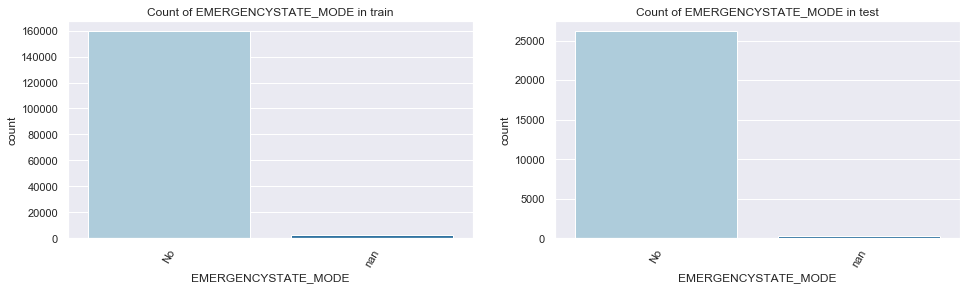

In [19]:
# explore categorical variables
categorical_var = [i for i in application_train.select_dtypes('object').columns]
for var in categorical_var:
    f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)
    sns.set(style="darkgrid")
    sns.countplot(x= var, data=application_train, palette="Paired", ax=axes[0])
    axes[0].set_title("Count of " + var + " in train")
    axes[0].set_xticklabels(labels=application_train[var].unique(),rotation=60)
    sns.countplot(x= var, data=application_test, palette="Paired", ax=axes[1])
    axes[1].set_title("Count of " + var + " in test")
    axes[1].set_xticklabels(labels=application_train[var].unique(),rotation=60)

---
## 3. Data manipulation & feature engineering
### application_train & application_test

In [20]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### Categorical variable：Label encoding 

In [22]:
# build function to get unique value from categorical variable
def categorical_unique_value_print(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtypes == 'object':
            print(col,':',dataframe[col].unique())

In [23]:
categorical_unique_value_print(application_train)

NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
CODE_GENDER : ['M' 'F' 'XNA']
FLAG_OWN_CAR : ['N' 'Y']
FLAG_OWN_REALTY : ['Y' 'N']
NAME_TYPE_SUITE : ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE : ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE : ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS : ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE : ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE : ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff'

In [24]:
categorical_unique_value_print(application_test)

NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
CODE_GENDER : ['F' 'M']
FLAG_OWN_CAR : ['N' 'Y']
FLAG_OWN_REALTY : ['Y' 'N']
NAME_TYPE_SUITE : ['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
NAME_INCOME_TYPE : ['Working' 'State servant' 'Pensioner' 'Commercial associate'
 'Businessman' 'Student' 'Unemployed']
NAME_EDUCATION_TYPE : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS : ['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
NAME_HOUSING_TYPE : ['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE : [nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/ba

In [25]:
# check missing value of categorical data
application_train.select_dtypes('object').isna().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [26]:
# build function to check the categorical variables' value in train & test
def categorical_value_set(dataframe1,dataframe2):
    for col in dataframe1.columns:
        if dataframe1[col].dtypes == 'object':
            value_set1 = set(dataframe1[col].unique())
            value_set2 = set(dataframe2[col].unique())
            set_difference1 = value_set1-value_set2
            set_difference2 = value_set2-value_set1
            if (len(set_difference1) != 0) | (len(set_difference2) != 0):
                print(col,set_difference1,set_difference2)

In [27]:
categorical_value_set(application_train,application_test)

CODE_GENDER {'XNA'} set()
NAME_INCOME_TYPE {'Maternity leave'} set()
NAME_FAMILY_STATUS {'Unknown'} set()


In [28]:
# there are three varibles contains different value in train and test set
# explore observations with XNA in CODE_GENDER in the train set
application_train[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
189640,319880,0,Revolving loans,XNA,Y,Y,0,247500.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0


In [29]:
# since there is no XNA in the target set, we decide to drop XNA in CODE_GENDER in train set
application_train = application_train.drop([ob for ob in application_train[application_train['CODE_GENDER'] == 'XNA'].index])

# check if XNA left in the train set
application_train[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [30]:
application_train[application_train['NAME_INCOME_TYPE']=='Maternity leave']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48949,156685,0,Revolving loans,M,N,N,0,360000.0,765000.0,76500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
109612,227123,0,Revolving loans,F,N,Y,2,135000.0,810000.0,40500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
218269,352877,1,Cash loans,F,N,Y,2,67500.0,1435500.0,40896.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
291432,437628,1,Cash loans,F,Y,Y,2,49500.0,423000.0,11286.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
295458,442305,0,Revolving loans,F,N,Y,1,90000.0,315000.0,15750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# drop 'Maternity leave' in NAME_INCOME_TYPE in train set
application_train = application_train.drop([ob for ob in application_train[application_train['NAME_INCOME_TYPE'] == 'Maternity leave'].index])

# check train set
application_train[application_train['NAME_INCOME_TYPE'] == 'Maternity leave']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [32]:
application_train[application_train['NAME_FAMILY_STATUS']=='Unknown']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
41982,148605,0,Revolving loans,M,N,Y,0,450000.0,675000.0,33750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
187348,317181,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
# drop Unknown in NAME_FAMILY_STATUS in train set
application_train = application_train.drop([ob for ob in application_train[application_train['NAME_FAMILY_STATUS'] == 'Unknown'].index])

# check train set
application_train[application_train['NAME_FAMILY_STATUS'] == 'Unknown']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [34]:
# double check if there is different in the train & test set
categorical_value_set(application_train,application_test)

In [35]:
# build function for label encoding for categorical variables
def labelencoding(dataframe):
    encoders = dict()
    for col_name in dataframe.select_dtypes('object').columns:
        series = dataframe[col_name]
        label_encoder = preprocessing.LabelEncoder()
        dataframe[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),\
                                      index=series[series.notnull()].index)
        encoders[col_name] = label_encoder
        print('finish label encoding for column: '+ col_name)
    return dataframe

In [36]:
labelencoding(application_train)
labelencoding(application_test)

finish label encoding for column: NAME_CONTRACT_TYPE
finish label encoding for column: CODE_GENDER
finish label encoding for column: FLAG_OWN_CAR
finish label encoding for column: FLAG_OWN_REALTY
finish label encoding for column: NAME_TYPE_SUITE
finish label encoding for column: NAME_INCOME_TYPE
finish label encoding for column: NAME_EDUCATION_TYPE
finish label encoding for column: NAME_FAMILY_STATUS
finish label encoding for column: NAME_HOUSING_TYPE
finish label encoding for column: OCCUPATION_TYPE
finish label encoding for column: WEEKDAY_APPR_PROCESS_START
finish label encoding for column: ORGANIZATION_TYPE
finish label encoding for column: FONDKAPREMONT_MODE
finish label encoding for column: HOUSETYPE_MODE
finish label encoding for column: WALLSMATERIAL_MODE
finish label encoding for column: EMERGENCYSTATE_MODE
finish label encoding for column: NAME_CONTRACT_TYPE
finish label encoding for column: CODE_GENDER
finish label encoding for column: FLAG_OWN_CAR
finish label encoding for 

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100042,0,0,1,1,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
6,100057,0,1,1,1,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,100065,0,1,0,1,0,166500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,100066,0,0,0,1,0,315000.0,364896.0,28957.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
9,100067,0,0,1,1,1,162000.0,45000.0,5337.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [37]:
# check if there is categorical 
application_train.select_dtypes('object').columns

Index([], dtype='object')

In [38]:
# check
print(application_train.shape)
print(application_test.shape)

(307500, 122)
(48744, 121)


####  Numeric Variable: 
#### Create new features, impute missing value to mean

In [39]:
# add new features to train
# Amount loaned relative to salary
application_train['LOAN_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_train['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']

In [40]:
# Number of overall payments
application_train['ANNUITY LENGTH'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']

In [41]:
# Social features
application_train['WORKING_LIFE_RATIO'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']
application_train['INCOME_PER_FAM'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_train['CHILDREN_RATIO'] = application_train['CNT_CHILDREN'] / application_train['CNT_FAM_MEMBERS']

In [42]:
## add new features to test

# Amount loaned relative to salary
application_test['LOAN_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
application_test['ANNUITY_INCOME_RATIO'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']
# Number of overall payments
application_test['ANNUITY LENGTH'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']
# Social features
application_test['WORKING_LIFE_RATIO'] = application_test['DAYS_EMPLOYED'] / application_test['DAYS_BIRTH']
application_test['INCOME_PER_FAM'] = application_test['AMT_INCOME_TOTAL'] / application_test['CNT_FAM_MEMBERS']
application_test['CHILDREN_RATIO'] = application_test['CNT_CHILDREN'] / application_test['CNT_FAM_MEMBERS']

In [43]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LOAN_INCOME_RATIO,ANNUITY_INCOME_RATIO,ANNUITY LENGTH,WORKING_LIFE_RATIO,INCOME_PER_FAM,CHILDREN_RATIO
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,2.007889,0.121978,16.461104,0.067329,202500.0,0.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,4.790750,0.132217,36.234085,0.070862,135000.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,2.000000,0.100000,20.000000,0.011814,67500.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,2.316167,0.219900,10.532818,0.159905,67500.0,0.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,4.222222,0.179963,23.461618,0.152418,121500.0,0.0


In [44]:
application_train.select_dtypes('float').describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307500.0,168797.123450,237126.307223,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307500.0,599025.945351,402493.590146,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307488.0,27108.477604,14493.600189,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307224.0,538394.285593,369445.877860,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
NAME_TYPE_SUITE,306210.0,5.219712,1.775648,0.000000e+00,6.000000,6.000000,6.000000,6.000000e+00
REGION_POPULATION_RELATIVE,307500.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_REGISTRATION,307500.0,-4986.152449,3522.883278,-2.467200e+04,-7479.250000,-4504.000000,-2010.000000,0.000000e+00
OWN_CAR_AGE,104579.0,12.061160,11.944969,0.000000e+00,5.000000,9.000000,15.000000,9.100000e+01
OCCUPATION_TYPE,211112.0,7.850771,4.400346,0.000000e+00,4.000000,8.000000,11.000000,1.700000e+01
CNT_FAM_MEMBERS,307500.0,2.152637,0.910668,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01


In [45]:
# check missing value for nemeric variables
application_train.select_dtypes('float').isna().sum()

AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    276
NAME_TYPE_SUITE                   1290
REGION_POPULATION_RELATIVE           0
DAYS_REGISTRATION                    0
OWN_CAR_AGE                     202921
OCCUPATION_TYPE                  96388
CNT_FAM_MEMBERS                      0
EXT_SOURCE_1                    173374
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60959
APARTMENTS_AVG                  156056
BASEMENTAREA_AVG                179938
YEARS_BEGINEXPLUATATION_AVG     150002
YEARS_BUILD_AVG                 204481
COMMONAREA_AVG                  214856
ELEVATORS_AVG                   163886
ENTRANCES_AVG                   154823
FLOORSMAX_AVG                   153015
FLOORSMIN_AVG                   208634
LANDAREA_AVG                    182583
LIVINGAPARTMENTS_AVG            210191
LIVINGAREA_AVG                  154345
NONLIVINGAPARTMENTS_AVG  

In [46]:
application_train_nona = application_train
for col in application_train.select_dtypes('float').columns:
    print(col)
    application_train_nona[col]= application_train_nona[col].fillna(application_train_nona[col].median())
    print('Finish filling the na for ' + col)
    
application_test_nona = application_test   
for col in application_test.select_dtypes('float').columns:
    print(col)
    application_test_nona[col]= application_test_nona[col].fillna(application_test_nona[col].median())
    print('Finish filling the na for ' + col)

AMT_INCOME_TOTAL
Finish filling the na for AMT_INCOME_TOTAL
AMT_CREDIT
Finish filling the na for AMT_CREDIT
AMT_ANNUITY
Finish filling the na for AMT_ANNUITY
AMT_GOODS_PRICE
Finish filling the na for AMT_GOODS_PRICE
NAME_TYPE_SUITE
Finish filling the na for NAME_TYPE_SUITE
REGION_POPULATION_RELATIVE
Finish filling the na for REGION_POPULATION_RELATIVE
DAYS_REGISTRATION
Finish filling the na for DAYS_REGISTRATION
OWN_CAR_AGE
Finish filling the na for OWN_CAR_AGE
OCCUPATION_TYPE
Finish filling the na for OCCUPATION_TYPE
CNT_FAM_MEMBERS
Finish filling the na for CNT_FAM_MEMBERS
EXT_SOURCE_1
Finish filling the na for EXT_SOURCE_1
EXT_SOURCE_2
Finish filling the na for EXT_SOURCE_2
EXT_SOURCE_3
Finish filling the na for EXT_SOURCE_3
APARTMENTS_AVG
Finish filling the na for APARTMENTS_AVG
BASEMENTAREA_AVG
Finish filling the na for BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
Finish filling the na for YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
Finish filling the na for YEARS_BUILD_AVG
COMMON

In [47]:
application_train.select_dtypes('float').shape[1] + application_train.select_dtypes('int').shape[1] == application_train.shape[1]

True

In [48]:
application_test.select_dtypes('float').shape[1] + application_test.select_dtypes('int').shape[1] == application_test.shape[1]

True

In [49]:
application_train_nona.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LOAN_INCOME_RATIO,ANNUITY_INCOME_RATIO,ANNUITY LENGTH,WORKING_LIFE_RATIO,INCOME_PER_FAM,CHILDREN_RATIO
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,2.007889,0.121978,16.461104,0.067329,202500.0,0.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,4.790750,0.132217,36.234085,0.070862,135000.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,2.000000,0.100000,20.000000,0.011814,67500.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,2.316167,0.219900,10.532818,0.159905,67500.0,0.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,4.222222,0.179963,23.461618,0.152418,121500.0,0.0


In [50]:
print(application_train.shape,application_test.shape)

(307500, 128) (48744, 127)


### previous_application

In [51]:
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
previous_app.select_dtypes('float').shape[1] + \
previous_app.select_dtypes('int').shape[1] + \
previous_app.select_dtypes('object').shape[1] == previous_app.shape[1]

True

In [53]:
# select the categorical variable from previous application
object_col = ['SK_ID_CURR','NFLAG_INSURED_ON_APPROVAL']+[col for col in previous_app.select_dtypes('object')]
object_col

['SK_ID_CURR',
 'NFLAG_INSURED_ON_APPROVAL',
 'NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [54]:
# one hot encoding for categorical variable
# aggregate by sum and average
pre_dummies_avg = pd.get_dummies(previous_app[object_col]).groupby('SK_ID_CURR').mean().add_suffix('_avg')
pre_dummies_sum = pd.get_dummies(previous_app[object_col]).groupby('SK_ID_CURR').sum().add_suffix('_sum')

In [55]:
# days variables include inappropriate value, replace with nan
day_col = ['SK_ID_CURR', 'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION'\
           ,'DAYS_LAST_DUE','DAYS_TERMINATION']
day_df = previous_app[day_col]
day_df_updated = day_df.replace(365243.0, np.nan).groupby('SK_ID_CURR').mean()
day_df_updated.head()

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
SK_ID_CURR,,,,,
100001.0,NaN,-1709.000000,-1499.000000,-1619.000000,-1612.000000
100002.0,NaN,-565.000000,125.000000,-25.000000,-17.000000
100003.0,NaN,-1274.333333,-1004.333333,-1054.333333,-1047.333333
100004.0,NaN,-784.000000,-694.000000,-724.000000,-714.000000
100005.0,NaN,-706.000000,-376.000000,-466.000000,-460.000000


In [56]:
# select the numeric variable from previous application
numeric_col = [col for col in previous_app.select_dtypes('int') if col not in ['SK_ID_PREV','HOUR_APPR_PROCESS_START','SELLERPLACE_AREA']]\
+ [col for col in previous_app.select_dtypes('float') if col not in day_col + ['NFLAG_INSURED_ON_APPROVAL']]

In [57]:
# aggregate numeric variable by average, max and min
pre_numeric_avg = previous_app[numeric_col].groupby('SK_ID_CURR').mean().add_suffix('_avg')
pre_numeric_max = previous_app[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_max')
pre_numeric_min = previous_app[numeric_col].groupby('SK_ID_CURR').min().add_suffix('_min')

In [58]:
# created from previous application count
previous_records = previous_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR'). \
count().rename(index=int, columns={"SK_ID_PREV": "CNT_PREV_APP"})
previous_records.head()

,CNT_PREV_APP
SK_ID_CURR,
100001,1
100002,1
100003,3
100004,1
100005,2


In [59]:
merge_frames = [previous_records, pre_dummies_avg, pre_dummies_sum, \
                pre_numeric_avg, pre_numeric_max,pre_numeric_min, \
                day_df_updated]
previous_app_updated = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)

In [60]:
previous_app_updated.select_dtypes('object').head()

""
SK_ID_CURR
100001
100002
100003
100004
100005


In [61]:
# check the size of cleaned previous application set
previous_app_updated.head()
print(previous_app_updated.shape)

(338857, 327)


### POS_CASH_balance

In [62]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [63]:
pos_cash_balance.select_dtypes('float').shape[1] + \
pos_cash_balance.select_dtypes('int').shape[1] + \
pos_cash_balance.select_dtypes('object').shape[1] == pos_cash_balance.shape[1]

True

In [64]:
# create weighted average for 'CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','SK_DPD', 'SK_DPD_DEF' columns
wm = lambda x: np.average(x, weights=-1/pos_cash_balance.loc[x.index, 'MONTHS_BALANCE'])
f = {'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm}

In [65]:
cash_avg = pos_cash_balance.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','SK_DPD', 'SK_DPD_DEF'].\
agg(f).add_suffix('_wavg')
cash_avg.head()

,CNT_INSTALMENT_wavg,CNT_INSTALMENT_FUTURE_wavg,SK_DPD_wavg,SK_DPD_DEF_wavg
SK_ID_CURR,,,,
100001,4.000000,1.575271,0.552756,0.552756
100002,24.000000,10.355523,0.000000,0.000000
100003,9.420817,5.370844,0.000000,0.000000
100004,3.734886,2.185806,0.000000,0.000000
100005,NaN,NaN,0.000000,0.000000


In [66]:
# select categorical variables
object_col = ['SK_ID_CURR']+[col for col in pos_cash_balance.select_dtypes('object')]
object_col

['SK_ID_CURR', 'NAME_CONTRACT_STATUS']

In [67]:
# create the most recent contract status feature
most_recent_index = pos_cash_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
most_recent_pos = pos_cash_balance.loc[most_recent_index, object_col]
most_recent_pos.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS
2197888,100001,Completed
6626366,100002,Active
5467865,100003,Completed
2446580,100004,Completed
9370202,100005,Completed


In [68]:
# select numeric variables
numeric_col = [col for col in pos_cash_balance.select_dtypes('int') if col not in ['SK_ID_PREV']]\
+ [col for col in pos_cash_balance.select_dtypes('float')]
numeric_col

['SK_ID_CURR',
 'MONTHS_BALANCE',
 'SK_DPD',
 'SK_DPD_DEF',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE']

In [69]:
# aggregate numeric variable by average, max and min
pos_numeric_avg = pos_cash_balance[numeric_col].groupby('SK_ID_CURR').mean().add_suffix('_avg')
pos_numeric_max = pos_cash_balance[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_max')
pos_numeric_min = pos_cash_balance[numeric_col].groupby('SK_ID_CURR').min().add_suffix('_min')

In [70]:
# create pos cash balance count feature
pos_records = previous_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR'). \
count().rename(index=int, columns={"SK_ID_PREV": "CNT_POS_CASH"})
pos_records.head()

,CNT_POS_CASH
SK_ID_CURR,
100001,1
100002,1
100003,3
100004,1
100005,2


In [71]:
merge_frames = [pos_records, cash_avg, most_recent_pos, pos_numeric_avg, pos_numeric_max,pos_numeric_min]
pos_cash_updated = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)

In [72]:
pos_cash_updated.select_dtypes('object').head()

,NAME_CONTRACT_STATUS
0,Completed
1,Active
2,Completed
3,Completed
4,Completed


In [73]:
labelencoding(pos_cash_updated)

finish label encoding for column: NAME_CONTRACT_STATUS


,SK_ID_CURR,CNT_POS_CASH,CNT_INSTALMENT_wavg,CNT_INSTALMENT_FUTURE_wavg,SK_DPD_wavg,SK_DPD_DEF_wavg,NAME_CONTRACT_STATUS,MONTHS_BALANCE_avg,SK_DPD_avg,SK_DPD_DEF_avg,...,MONTHS_BALANCE_max,SK_DPD_max,SK_DPD_DEF_max,CNT_INSTALMENT_max,CNT_INSTALMENT_FUTURE_max,MONTHS_BALANCE_min,SK_DPD_min,SK_DPD_DEF_min,CNT_INSTALMENT_min,CNT_INSTALMENT_FUTURE_min
0,100001,1,4.000000,1.575271,0.552756,0.552756,3.0,-72.555556,0.777778,0.777778,...,-53.0,7.0,7.0,4.0,4.0,-96.0,0.0,0.0,4.0,0.0
1,100002,1,24.000000,10.355523,0.000000,0.000000,0.0,-10.000000,0.000000,0.000000,...,-1.0,0.0,0.0,24.0,24.0,-19.0,0.0,0.0,24.0,6.0
2,100003,3,9.420817,5.370844,0.000000,0.000000,3.0,-43.785714,0.000000,0.000000,...,-18.0,0.0,0.0,12.0,12.0,-77.0,0.0,0.0,6.0,0.0
3,100004,1,3.734886,2.185806,0.000000,0.000000,3.0,-25.500000,0.000000,0.000000,...,-24.0,0.0,0.0,4.0,4.0,-27.0,0.0,0.0,3.0,0.0
4,100005,2,NaN,NaN,0.000000,0.000000,3.0,-20.000000,0.000000,0.000000,...,-15.0,0.0,0.0,12.0,12.0,-25.0,0.0,0.0,9.0,0.0
5,100006,9,NaN,NaN,0.000000,0.000000,0.0,-9.619048,0.000000,0.000000,...,-1.0,0.0,0.0,48.0,48.0,-20.0,0.0,0.0,1.0,0.0
6,100007,6,20.555758,12.393130,0.000000,0.000000,0.0,-33.636364,0.000000,0.000000,...,-1.0,0.0,0.0,24.0,24.0,-77.0,0.0,0.0,10.0,0.0
7,100008,5,12.198368,4.677985,194.219101,0.000000,3.0,-43.662651,339.060241,0.000000,...,-2.0,1294.0,0.0,30.0,30.0,-84.0,0.0,0.0,6.0,0.0
8,100009,7,9.021520,4.358065,0.000000,0.000000,0.0,-33.062500,0.000000,0.000000,...,-1.0,0.0,0.0,12.0,12.0,-96.0,0.0,0.0,5.0,0.0
9,100010,1,10.000000,4.663729,0.000000,0.000000,3.0,-30.000000,0.000000,0.000000,...,-25.0,0.0,0.0,10.0,10.0,-35.0,0.0,0.0,10.0,0.0


In [74]:
pos_cash_updated.shape

(338857, 22)

### credit_card_balance

In [75]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [76]:
credit_card_balance.select_dtypes('float').shape[1] + \
credit_card_balance.select_dtypes('int').shape[1] + \
credit_card_balance.select_dtypes('object').shape[1] == credit_card_balance.shape[1]

True

In [77]:
# create weighted average for month balance
wm = lambda x: np.average(x, weights=-1/credit_card_balance.loc[x.index, 'MONTHS_BALANCE'])

In [78]:
credit_card_avgs = credit_card_balance.groupby('SK_ID_CURR').agg(wm).drop(columns = 'SK_ID_PREV').add_suffix('_wavg')
credit_card_avgs.head()

,MONTHS_BALANCE_wavg,AMT_BALANCE_wavg,AMT_CREDIT_LIMIT_ACTUAL_wavg,AMT_DRAWINGS_ATM_CURRENT_wavg,AMT_DRAWINGS_CURRENT_wavg,AMT_DRAWINGS_OTHER_CURRENT_wavg,AMT_DRAWINGS_POS_CURRENT_wavg,AMT_INST_MIN_REGULARITY_wavg,AMT_PAYMENT_CURRENT_wavg,AMT_PAYMENT_TOTAL_CURRENT_wavg,AMT_RECEIVABLE_PRINCIPAL_wavg,AMT_RECIVABLE_wavg,AMT_TOTAL_RECEIVABLE_wavg,CNT_DRAWINGS_ATM_CURRENT_wavg,CNT_DRAWINGS_CURRENT_wavg,CNT_DRAWINGS_OTHER_CURRENT_wavg,CNT_DRAWINGS_POS_CURRENT_wavg,CNT_INSTALMENT_MATURE_CUM_wavg,SK_DPD_wavg,SK_DPD_DEF_wavg
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,
100006,-2.448980,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.0,NaN,0.000000,0.000000,0.00000,0.00000,NaN,0.000000,NaN,NaN,0.0,0.000000,0.000000
100011,-18.967766,16910.295179,128058.923979,615.170784,615.170784,0.0,0.0,NaN,2057.194314,1571.905386,16244.769731,16887.87068,16887.87068,0.01367,0.013670,0.0,0.0,NaN,0.000000,0.000000
100013,-18.652500,4291.324329,76824.733090,NaN,1368.505798,NaN,NaN,NaN,1924.271728,1631.036153,4073.078347,4274.18176,4274.18176,NaN,0.054914,NaN,NaN,NaN,0.002816,0.002816
100021,-6.813332,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.0,NaN,0.000000,0.000000,0.00000,0.00000,NaN,0.000000,NaN,NaN,0.0,0.000000,0.000000
100023,-6.742270,0.000000,160220.577058,NaN,0.000000,NaN,NaN,0.0,NaN,0.000000,0.000000,0.00000,0.00000,NaN,0.000000,NaN,NaN,0.0,0.000000,0.000000


In [79]:
# select categorical variables
object_col = ['SK_ID_CURR']+[col for col in credit_card_balance.select_dtypes('object')]
object_col

['SK_ID_CURR', 'NAME_CONTRACT_STATUS']

In [80]:
# create most recent feature for categorical data
most_recent_index = credit_card_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
most_recent_credit = credit_card_balance.loc[most_recent_index, object_col]
most_recent_credit.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS
584804,100006,Active
2739019,100011,Active
2673656,100013,Active
1278805,100021,Completed
778090,100023,Active


In [81]:
# select numeric variables
numeric_col = [col for col in credit_card_balance.select_dtypes('int') if col not in ['SK_ID_PREV']]\
+ [col for col in credit_card_balance.select_dtypes('float')]
numeric_col

['SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'CNT_DRAWINGS_CURRENT',
 'SK_DPD',
 'SK_DPD_DEF',
 'AMT_BALANCE',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM']

In [82]:
# aggregate numeric variable by average, max and min
credit_numeric_avg = credit_card_balance[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_avg')
credit_numeric_max = credit_card_balance[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_max')
credit_numeric_min = credit_card_balance[numeric_col].groupby('SK_ID_CURR').min().add_suffix('_min')

In [83]:
# create credit card balance records count feature
credit_records = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR'). \
count().rename(index=int, columns={"SK_ID_PREV": "CNT_CREDIT_CARD"})
credit_records.head()

,CNT_CREDIT_CARD
SK_ID_CURR,
100006,6
100011,74
100013,96
100021,17
100023,8


In [84]:
merge_frames = [credit_records, credit_card_avgs, credit_numeric_avg, credit_numeric_max, \
                credit_numeric_min, most_recent_credit]
credit_card_updated = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)
credit_card_updated.head()

,SK_ID_CURR,CNT_CREDIT_CARD,MONTHS_BALANCE_wavg,AMT_BALANCE_wavg,AMT_CREDIT_LIMIT_ACTUAL_wavg,AMT_DRAWINGS_ATM_CURRENT_wavg,AMT_DRAWINGS_CURRENT_wavg,AMT_DRAWINGS_OTHER_CURRENT_wavg,AMT_DRAWINGS_POS_CURRENT_wavg,AMT_INST_MIN_REGULARITY_wavg,...,AMT_PAYMENT_CURRENT_min,AMT_PAYMENT_TOTAL_CURRENT_min,AMT_RECEIVABLE_PRINCIPAL_min,AMT_RECIVABLE_min,AMT_TOTAL_RECEIVABLE_min,CNT_DRAWINGS_ATM_CURRENT_min,CNT_DRAWINGS_OTHER_CURRENT_min,CNT_DRAWINGS_POS_CURRENT_min,CNT_INSTALMENT_MATURE_CUM_min,NAME_CONTRACT_STATUS
0,100006,6,-2.448980,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.0,...,NaN,0.0,0.0,0.000,0.000,NaN,NaN,NaN,0.0,Active
1,100011,74,-18.967766,16910.295179,128058.923979,615.170784,615.170784,0.0,0.0,NaN,...,0.0,0.0,0.0,-563.355,-563.355,0.0,0.0,0.0,1.0,Active
2,100013,96,-18.652500,4291.324329,76824.733090,NaN,1368.505798,NaN,NaN,NaN,...,0.0,0.0,0.0,-274.320,-274.320,0.0,0.0,0.0,1.0,Active
3,100021,17,-6.813332,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.0,...,NaN,0.0,0.0,0.000,0.000,NaN,NaN,NaN,0.0,Completed
4,100023,8,-6.742270,0.000000,160220.577058,NaN,0.000000,NaN,NaN,0.0,...,NaN,0.0,0.0,0.000,0.000,NaN,NaN,NaN,0.0,Active


In [85]:
credit_card_updated.select_dtypes('object').head()

,NAME_CONTRACT_STATUS
0,Active
1,Active
2,Active
3,Completed
4,Active


In [86]:
labelencoding(credit_card_updated)

finish label encoding for column: NAME_CONTRACT_STATUS


,SK_ID_CURR,CNT_CREDIT_CARD,MONTHS_BALANCE_wavg,AMT_BALANCE_wavg,AMT_CREDIT_LIMIT_ACTUAL_wavg,AMT_DRAWINGS_ATM_CURRENT_wavg,AMT_DRAWINGS_CURRENT_wavg,AMT_DRAWINGS_OTHER_CURRENT_wavg,AMT_DRAWINGS_POS_CURRENT_wavg,AMT_INST_MIN_REGULARITY_wavg,...,AMT_PAYMENT_CURRENT_min,AMT_PAYMENT_TOTAL_CURRENT_min,AMT_RECEIVABLE_PRINCIPAL_min,AMT_RECIVABLE_min,AMT_TOTAL_RECEIVABLE_min,CNT_DRAWINGS_ATM_CURRENT_min,CNT_DRAWINGS_OTHER_CURRENT_min,CNT_DRAWINGS_POS_CURRENT_min,CNT_INSTALMENT_MATURE_CUM_min,NAME_CONTRACT_STATUS
0,100006,6,-2.448980,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,...,NaN,0.0,0.000,0.000,0.000,NaN,NaN,NaN,0.0,0
1,100011,74,-18.967766,16910.295179,128058.923979,615.170784,615.170784,0.000000,0.000000,NaN,...,0.000,0.0,0.000,-563.355,-563.355,0.0,0.0,0.0,1.0,0
2,100013,96,-18.652500,4291.324329,76824.733090,NaN,1368.505798,NaN,NaN,NaN,...,0.000,0.0,0.000,-274.320,-274.320,0.0,0.0,0.0,1.0,0
3,100021,17,-6.813332,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,...,NaN,0.0,0.000,0.000,0.000,NaN,NaN,NaN,0.0,1
4,100023,8,-6.742270,0.000000,160220.577058,NaN,0.000000,NaN,NaN,0.000000,...,NaN,0.0,0.000,0.000,0.000,NaN,NaN,NaN,0.0,0
5,100028,49,-10.939440,15993.090127,225000.000000,NaN,11048.519574,NaN,NaN,NaN,...,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,1.0,0
6,100036,12,-5.504249,0.000000,84815.709116,NaN,0.000000,NaN,NaN,0.000000,...,NaN,0.0,0.000,0.000,0.000,NaN,NaN,NaN,0.0,0
7,100042,84,-16.753181,8843.990806,57283.202246,805.742150,1512.040904,614.047839,92.250915,NaN,...,0.000,0.0,0.000,-32.850,-32.850,0.0,0.0,0.0,1.0,0
8,100043,33,-8.070831,71027.895576,128945.750800,660.340729,3805.401213,0.000000,3145.060484,NaN,...,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,1.0,0
9,100047,36,-14.874744,0.000000,212672.325077,NaN,0.000000,NaN,NaN,NaN,...,NaN,0.0,0.000,0.000,0.000,NaN,NaN,NaN,0.0,0


In [87]:
print(credit_card_updated.shape)

(103558, 83)


### installments_payments

In [88]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [89]:
# revise variable type to categorical
installments_payments['NUM_INSTALMENT_VERSION'] = installments_payments['NUM_INSTALMENT_VERSION'].astype(object)
installments_payments['NUM_INSTALMENT_NUMBER'] = installments_payments['NUM_INSTALMENT_NUMBER'].astype(object)

In [90]:
# select categorical variable
object_col1 = ['SK_ID_CURR']+[col for col in installments_payments.select_dtypes('object')]
object_col1

['SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER']

In [91]:
# create most recent status fearure for categorical variable
most_recent_index = installments_payments.groupby('SK_ID_CURR')['AMT_INSTALMENT'].idxmax()
most_recent_ins = installments_payments.loc[most_recent_index, object_col1]
most_recent_ins.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER
2624024,100001,2,4
442432,100002,2,19
1179410,100003,2,7
3582086,100004,2,3
996531,100005,2,9


In [92]:
object_col2 = ['SK_ID_CURR', 'NUM_INSTALMENT_VERSION']

In [93]:
# one hot encoding for installment payment version 
# aggregate by sum and average
ins_dummies = pd.get_dummies(installments_payments[object_col2])
ins_dummies_avg = ins_dummies.groupby('SK_ID_CURR').mean().add_suffix('_avg')
ins_dummies_sum = ins_dummies.groupby('SK_ID_CURR').sum().add_suffix('_sum')

In [94]:
if_delayed = installments_payments[['SK_ID_CURR','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']]

In [95]:
# create if installment payment delay feature
if_delayed['if_previous_delayed'] = if_delayed\
.apply(lambda x : 1 if x['DAYS_INSTALMENT'] < x['DAYS_ENTRY_PAYMENT'] else 0, axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [96]:
# aggregate by sum
delay_sum = if_delayed[['SK_ID_CURR','if_previous_delayed']].groupby('SK_ID_CURR').sum().\
rename(index=int, columns={"if_previous_delayed": "CNT_DELAY"})
delay_sum.head()

,CNT_DELAY
SK_ID_CURR,
100001,1
100002,0
100003,0
100004,0
100005,1


In [97]:
# aggregate by average
delay_avg = if_delayed[['SK_ID_CURR','if_previous_delayed']].groupby('SK_ID_CURR').mean().\
rename(index=int, columns={"if_previous_delayed": "AVG_DELAY"})
delay_avg.head()

,AVG_DELAY
SK_ID_CURR,
100001,0.142857
100002,0.000000
100003,0.000000
100004,0.000000
100005,0.111111


In [98]:
# select numeric variables
numeric_col = [col for col in installments_payments.select_dtypes('int') if col not in ['SK_ID_PREV','NUM_INSTALMENT_NUMBER']]\
+ [col for col in installments_payments.select_dtypes('float')]

In [99]:
# aggregate by average, max and min
ins_numeric_avg = installments_payments[numeric_col].groupby('SK_ID_CURR').mean().add_suffix('_avg')
ins_numeric_max = installments_payments[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_max')
ins_numeric_min = installments_payments[numeric_col].groupby('SK_ID_CURR').min().add_suffix('_min')

In [100]:
# create installment payments record count
ins_records = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR'). \
count().rename(index=int, columns={"SK_ID_PREV": "CNT_INSTALLMENT_PAYMENTS"})
ins_records.head()

,CNT_INSTALLMENT_PAYMENTS
SK_ID_CURR,
100001,7
100002,19
100003,25
100004,3
100005,9


In [101]:
merge_frames = [ins_records, most_recent_ins, ins_dummies_avg, ins_dummies_sum, \
                delay_sum, delay_avg,\
                ins_numeric_avg, ins_numeric_max, ins_numeric_min]
ins_payment_updated = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)
ins_payment_updated.head()

,SK_ID_CURR,CNT_INSTALLMENT_PAYMENTS,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_VERSION_0.0_avg,NUM_INSTALMENT_VERSION_1.0_avg,NUM_INSTALMENT_VERSION_2.0_avg,NUM_INSTALMENT_VERSION_3.0_avg,NUM_INSTALMENT_VERSION_4.0_avg,NUM_INSTALMENT_VERSION_5.0_avg,...,AMT_INSTALMENT_avg,AMT_PAYMENT_avg,DAYS_INSTALMENT_max,DAYS_ENTRY_PAYMENT_max,AMT_INSTALMENT_max,AMT_PAYMENT_max,DAYS_INSTALMENT_min,DAYS_ENTRY_PAYMENT_min,AMT_INSTALMENT_min,AMT_PAYMENT_min
0,100001,7,2,4,0.0,0.857143,0.142857,0.0,0.0,0.0,...,5885.132143,5885.132143,-1619.0,-1628.0,17397.900,17397.900,-2916.0,-2916.0,3951.000,3951.000
1,100002,19,2,19,0.0,0.947368,0.052632,0.0,0.0,0.0,...,11559.247105,11559.247105,-25.0,-49.0,53093.745,53093.745,-565.0,-587.0,9251.775,9251.775
2,100003,25,2,7,0.0,0.960000,0.040000,0.0,0.0,0.0,...,64754.586000,64754.586000,-536.0,-544.0,560835.360,560835.360,-2310.0,-2324.0,6662.970,6662.970
3,100004,3,2,3,0.0,0.666667,0.333333,0.0,0.0,0.0,...,7096.155000,7096.155000,-724.0,-727.0,10573.965,10573.965,-784.0,-795.0,5357.250,5357.250
4,100005,9,2,9,0.0,0.888889,0.111111,0.0,0.0,0.0,...,6240.205000,6240.205000,-466.0,-470.0,17656.245,17656.245,-706.0,-736.0,4813.200,4813.200


In [102]:
ins_payment_updated.select_dtypes('object').head()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER
0,2,4
1,2,19
2,2,7
3,2,3
4,2,9


In [103]:
labelencoding(ins_payment_updated)

finish label encoding for column: NUM_INSTALMENT_VERSION
finish label encoding for column: NUM_INSTALMENT_NUMBER


,SK_ID_CURR,CNT_INSTALLMENT_PAYMENTS,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_VERSION_0.0_avg,NUM_INSTALMENT_VERSION_1.0_avg,NUM_INSTALMENT_VERSION_2.0_avg,NUM_INSTALMENT_VERSION_3.0_avg,NUM_INSTALMENT_VERSION_4.0_avg,NUM_INSTALMENT_VERSION_5.0_avg,...,AMT_INSTALMENT_avg,AMT_PAYMENT_avg,DAYS_INSTALMENT_max,DAYS_ENTRY_PAYMENT_max,AMT_INSTALMENT_max,AMT_PAYMENT_max,DAYS_INSTALMENT_min,DAYS_ENTRY_PAYMENT_min,AMT_INSTALMENT_min,AMT_PAYMENT_min
0,100001,7,2,3,0.000000,0.857143,0.142857,0.000000,0.000000,0.000000,...,5885.132143,5885.132143,-1619.0,-1628.0,17397.900,17397.900,-2916.0,-2916.0,3951.000,3951.000
1,100002,19,2,18,0.000000,0.947368,0.052632,0.000000,0.000000,0.000000,...,11559.247105,11559.247105,-25.0,-49.0,53093.745,53093.745,-565.0,-587.0,9251.775,9251.775
2,100003,25,2,6,0.000000,0.960000,0.040000,0.000000,0.000000,0.000000,...,64754.586000,64754.586000,-536.0,-544.0,560835.360,560835.360,-2310.0,-2324.0,6662.970,6662.970
3,100004,3,2,2,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,...,7096.155000,7096.155000,-724.0,-727.0,10573.965,10573.965,-784.0,-795.0,5357.250,5357.250
4,100005,9,2,8,0.000000,0.888889,0.111111,0.000000,0.000000,0.000000,...,6240.205000,6240.205000,-466.0,-470.0,17656.245,17656.245,-706.0,-736.0,4813.200,4813.200
5,100006,16,2,0,0.000000,0.875000,0.125000,0.000000,0.000000,0.000000,...,62947.088438,62947.088438,-11.0,-12.0,691786.890,691786.890,-545.0,-575.0,2482.920,2482.920
6,100007,66,1,8,0.000000,0.833333,0.166667,0.000000,0.000000,0.000000,...,12666.444545,12214.060227,-14.0,-14.0,22678.785,22678.785,-2326.0,-2318.0,1821.780,0.180
7,100008,35,2,7,0.000000,0.971429,0.028571,0.000000,0.000000,0.000000,...,27702.964286,27360.502714,-69.0,-82.0,432218.295,432218.295,-2491.0,-2519.0,8003.475,227.160
8,100009,51,1,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,9568.531765,9568.531765,-43.0,-58.0,17341.605,17341.605,-2908.0,-2914.0,6155.280,6155.280
9,100010,10,1,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,27449.208000,27449.208000,-769.0,-774.0,27463.410,27463.410,-1039.0,-1069.0,27321.390,27321.390


In [104]:
ins_payment_updated.shape

(339587, 148)

### bureau_balance & bureau

In [105]:
# Bureau balance data get the most recent bureau balance status
most_recent_index = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
bureau_balance_updated = bureau_balance.loc[most_recent_index, :]
bureau_balance_updated.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
26079753,5001709,0,C
2846316,5001710,0,C
2846399,5001711,0,X
2846403,5001712,0,C
1415228,5001713,0,X


In [106]:
# merge burerau and bureau balance dataframe
bureau_df_merge = bureau.merge(bureau_balance_updated, how = 'left', left_on = 'SK_ID_BUREAU', right_on = 'SK_ID_BUREAU')
bureau_df_merge.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN


In [107]:
bureau_df_merge.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [108]:
# select categorical variable
object_col = ['SK_ID_CURR']+[col for col in bureau_df_merge.select_dtypes('object')]
object_col

['SK_ID_CURR', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS']

In [109]:
# create most recent bureau records
most_recent_index = bureau_df_merge.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].idxmax()
most_recent_bureau = bureau_df_merge.loc[most_recent_index, object_col]
most_recent_bureau.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS
248489.0,100001.0,Active,currency 1,Consumer credit,0
1337779.0,100002.0,Active,currency 1,Consumer credit,C
1024669.0,100003.0,Active,currency 1,Credit card,NaN
363105.0,100004.0,Closed,currency 1,Consumer credit,NaN
1421815.0,100005.0,Active,currency 1,Consumer credit,0


In [110]:
# select numeric variable
numeric_col = [col for col in bureau.select_dtypes('int') if col not in ['SK_ID_BUREAU']]\
+ [col for col in bureau.select_dtypes('float')]
numeric_col

['SK_ID_CURR',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'DAYS_CREDIT_UPDATE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_ANNUITY']

In [111]:
# aggregate by average, max and min
bureau_numeric_avg = bureau_df_merge[numeric_col].groupby('SK_ID_CURR').mean().add_suffix('_avg')
bureau_numeric_max = bureau_df_merge[numeric_col].groupby('SK_ID_CURR').max().add_suffix('_max')
bureau_numeric_min = bureau_df_merge[numeric_col].groupby('SK_ID_CURR').min().add_suffix('_min')

In [112]:
# create bureau records feature
bureau_records = bureau_df_merge[['SK_ID_CURR','SK_ID_BUREAU']].groupby('SK_ID_CURR').count().\
rename(index=int, columns={"SK_ID_BUREAU": "CNT_BUREAU_RECORDS"})
bureau_records.head()

,CNT_BUREAU_RECORDS
SK_ID_CURR,
100001,7
100002,8
100003,4
100004,2
100005,3


In [113]:
merge_frames = [bureau_records, most_recent_bureau, bureau_numeric_avg, bureau_numeric_max, bureau_numeric_min]
bureau_updated = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)
bureau_updated.head()

,SK_ID_CURR,CNT_BUREAU_RECORDS,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS,DAYS_CREDIT_avg,CREDIT_DAY_OVERDUE_avg,CNT_CREDIT_PROLONG_avg,DAYS_CREDIT_UPDATE_avg,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min
0,100001,7,Active,currency 1,Consumer credit,0,-735.000000,0.0,0.0,-93.142857,...,0,-155,-1329.0,-1328.0,NaN,85500.0,0.0,0.0,0.0,0.0
1,100002,8,Active,currency 1,Consumer credit,C,-874.000000,0.0,0.0,-499.875000,...,0,-1185,-1072.0,-1185.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,4,Active,currency 1,Credit card,NaN,-1400.750000,0.0,0.0,-816.000000,...,0,-2131,-2434.0,-2131.0,0.0,22248.0,0.0,0.0,0.0,NaN
3,100004,2,Closed,currency 1,Consumer credit,NaN,-867.000000,0.0,0.0,-532.000000,...,0,-682,-595.0,-683.0,0.0,94500.0,0.0,0.0,0.0,NaN
4,100005,3,Active,currency 1,Consumer credit,0,-190.666667,0.0,0.0,-54.333333,...,0,-121,-128.0,-123.0,0.0,29826.0,0.0,0.0,0.0,0.0


In [114]:
bureau_updated.select_dtypes('object').head()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS
0,Active,currency 1,Consumer credit,0
1,Active,currency 1,Consumer credit,C
2,Active,currency 1,Credit card,NaN
3,Closed,currency 1,Consumer credit,NaN
4,Active,currency 1,Consumer credit,0


In [115]:
bureau_updated.STATUS.unique()

array(['0', 'C', nan, 'X', '1', '5', '2', '3', '4'], dtype=object)

In [116]:
labelencoding(bureau_updated)

finish label encoding for column: CREDIT_ACTIVE
finish label encoding for column: CREDIT_CURRENCY
finish label encoding for column: CREDIT_TYPE
finish label encoding for column: STATUS


,SK_ID_CURR,CNT_BUREAU_RECORDS,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS,DAYS_CREDIT_avg,CREDIT_DAY_OVERDUE_avg,CNT_CREDIT_PROLONG_avg,DAYS_CREDIT_UPDATE_avg,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min
0,100001,7,0.0,0.0,3.0,0.0,-735.000000,0.0,0.000000,-93.142857,...,0,-155,-1329.0,-1328.0,NaN,85500.000,0.000,0.00,0.0,0.000
1,100002,8,0.0,0.0,3.0,6.0,-874.000000,0.0,0.000000,-499.875000,...,0,-1185,-1072.0,-1185.0,0.0,0.000,0.000,0.00,0.0,0.000
2,100003,4,0.0,0.0,4.0,NaN,-1400.750000,0.0,0.000000,-816.000000,...,0,-2131,-2434.0,-2131.0,0.0,22248.000,0.000,0.00,0.0,NaN
3,100004,2,2.0,0.0,3.0,NaN,-867.000000,0.0,0.000000,-532.000000,...,0,-682,-595.0,-683.0,0.0,94500.000,0.000,0.00,0.0,NaN
4,100005,3,0.0,0.0,3.0,0.0,-190.666667,0.0,0.000000,-54.333333,...,0,-121,-128.0,-123.0,0.0,29826.000,0.000,0.00,0.0,0.000
5,100007,1,2.0,0.0,3.0,NaN,-1149.000000,0.0,0.000000,-783.000000,...,0,-783,-783.0,-783.0,0.0,146250.000,0.000,0.00,0.0,NaN
6,100008,3,0.0,0.0,3.0,NaN,-757.333333,0.0,0.000000,-611.000000,...,0,-1027,-853.0,-1028.0,0.0,95134.500,0.000,0.00,0.0,NaN
7,100009,18,2.0,0.0,3.0,NaN,-1271.500000,0.0,0.000000,-851.611111,...,0,-2152,-2152.0,-2152.0,0.0,35770.500,0.000,0.00,0.0,NaN
8,100010,2,0.0,0.0,3.0,6.0,-1939.500000,0.0,0.000000,-578.000000,...,0,-1138,-928.0,-1138.0,NaN,315000.000,0.000,0.00,0.0,NaN
9,100011,4,2.0,0.0,3.0,NaN,-1773.000000,0.0,0.000000,-1454.750000,...,0,-2172,-2173.0,-2197.0,0.0,54000.000,0.000,0.00,0.0,NaN


In [117]:
bureau_updated.shape

(305811, 42)

---
#### Join all the data set

In [118]:
# print the size of each data set
print('Size of processed application_train data', application_train_nona.shape)
print('Size of processed application_test data', application_test_nona.shape)
print('Size of processed POS_CASH_balance data', pos_cash_updated.shape)
print('Size of processed bureau data', bureau_updated.shape)
print('Size of processed previous_application data', previous_app_updated.shape)
print('Size of processed installments_payments data', ins_payment_updated.shape)
print('Size of processed credit_card_balance data', credit_card_updated.shape)

Size of processed application_train data (307500, 128)
Size of processed application_test data (48744, 127)
Size of processed POS_CASH_balance data (338857, 22)
Size of processed bureau data (305811, 42)
Size of processed previous_application data (338857, 327)
Size of processed installments_payments data (339587, 148)
Size of processed credit_card_balance data (103558, 83)


In [119]:
# join all the data sets -- using train & test nona
merge_frames = [application_train_nona, previous_app_updated, pos_cash_updated, \
                credit_card_updated, ins_payment_updated, bureau_updated]
train_frame = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)
train_frame.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min_y
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.0,-1185.0,-1072.0,-1185.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,-2131.0,-2434.0,-2131.0,0.0,22248.0,0.0,0.0,0.0,NaN
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,-682.0,-595.0,-683.0,0.0,94500.0,0.0,0.0,0.0,NaN
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,-783.0,-783.0,-783.0,0.0,146250.0,0.0,0.0,0.0,NaN


In [120]:
train_frame.shape

(307500, 746)

In [121]:
# test
merge_frames = [application_test_nona, previous_app_updated, pos_cash_updated, \
                credit_card_updated, ins_payment_updated, bureau_updated]
test_frame = functools.reduce(lambda left,right: pd.merge(left,right,on=['SK_ID_CURR'], how='left'), merge_frames)
test_frame.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min_y
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0.0,-155.0,-1329.0,-1328.0,NaN,85500.00,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0.0,-121.0,-128.0,-123.0,0.0,29826.00,0.0,0.0,0.0,0.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0.0,-1334.0,-1707.0,-1334.0,19305.0,26490.06,0.0,NaN,0.0,0.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,-1564.0,-1862.0,-1862.0,0.0,0.00,0.0,0.0,0.0,0.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
test_frame.shape

(48744, 745)

### Feature selection
#### Drop Collinear Variables

In [123]:
# threshold for removing correlated variables
threshold = 0.9

# absolute value correlation matrix
corr_matrix = train_frame.corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min_y
SK_ID_CURR,1.000000,0.002137,0.001697,0.000715,0.001208,0.000698,0.001140,0.001808,0.000346,0.000415,...,0.001353,0.001653,0.000107,0.000894,0.003602,0.000581,0.000449,0.000163,0.002216,0.001851
TARGET,0.002137,1.000000,0.030868,0.054729,0.021862,0.006160,0.019143,0.003970,0.030390,0.012812,...,0.000182,0.042866,0.034282,0.055892,0.002329,0.010765,0.000241,0.004779,0.000003,0.002542
NAME_CONTRACT_TYPE,0.001697,0.030868,1.000000,0.008763,0.004046,0.067151,0.029976,0.003552,0.221664,0.241604,...,0.004671,0.032065,0.037337,0.033770,0.001508,0.022307,0.016418,0.017828,0.004322,0.002576
CODE_GENDER,0.000715,0.054729,0.008763,1.000000,0.345858,0.044363,0.047409,0.074720,0.021598,0.076974,...,0.010034,0.040337,0.035401,0.038079,0.006008,0.039287,0.021521,0.010425,0.001812,0.014651
FLAG_OWN_CAR,0.001208,0.021862,0.004046,0.345858,1.000000,0.002818,0.102039,0.083387,0.116236,0.141609,...,0.002761,0.012457,0.013501,0.013372,0.003208,0.036658,0.017265,0.004832,0.002241,0.006439


In [124]:
# upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CNT_CREDIT_PROLONG_min,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_ENDDATE_min,DAYS_ENDDATE_FACT_min,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,AMT_ANNUITY_min_y
SK_ID_CURR,NaN,0.002137,0.001697,0.000715,0.001208,0.000698,0.001140,0.001808,0.000346,0.000415,...,0.001353,0.001653,0.000107,0.000894,0.003602,0.000581,0.000449,0.000163,0.002216,0.001851
TARGET,NaN,NaN,0.030868,0.054729,0.021862,0.006160,0.019143,0.003970,0.030390,0.012812,...,0.000182,0.042866,0.034282,0.055892,0.002329,0.010765,0.000241,0.004779,0.000003,0.002542
NAME_CONTRACT_TYPE,NaN,NaN,NaN,0.008763,0.004046,0.067151,0.029976,0.003552,0.221664,0.241604,...,0.004671,0.032065,0.037337,0.033770,0.001508,0.022307,0.016418,0.017828,0.004322,0.002576
CODE_GENDER,NaN,NaN,NaN,NaN,0.345858,0.044363,0.047409,0.074720,0.021598,0.076974,...,0.010034,0.040337,0.035401,0.038079,0.006008,0.039287,0.021521,0.010425,0.001812,0.014651
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,0.002818,0.102039,0.083387,0.116236,0.141609,...,0.002761,0.012457,0.013501,0.013372,0.003208,0.036658,0.017265,0.004832,0.002241,0.006439


In [125]:
# select columns with correlations above threshold
collinear_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(collinear_drop)))

There are 178 columns to remove.


In [126]:
# drop the variable with high collinearity
train = train_frame.drop(columns = collinear_drop)
test = test_frame.drop(columns = collinear_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307500, 568)
Testing shape:  (48744, 567)


#### Delete variable with missing value > 75%

In [127]:
# check the missing value for train and test set
train_missing = missing_value_df(train)
test_missing = missing_value_df(test)

In [128]:
# select the columns with missing value higher than 75%
all_missing = list(set(train_missing[train_missing['missing_percent']>75]['col_name'])|\
set(train_missing[train_missing['missing_percent']>75]['col_name']))
missing_drop = [col for col in all_missing]
print('There are %d columns to remove.' % (len(missing_drop)))

There are 22 columns to remove.


In [129]:
train = train.drop(columns = missing_drop)
train.shape

(307500, 546)

In [130]:
test = test.drop(columns = missing_drop)
test.shape

(48744, 545)

#### Feature Selection through Feature Importances


In [131]:
print(train.shape,test.shape)

(307500, 546) (48744, 545)


In [132]:
# save the labels because aligning will remove this column
train_labels = train['TARGET']
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train_ivs = train.drop(columns = ['SK_ID_CURR','TARGET'])
test_ivs = test.drop(columns = ['SK_ID_CURR'])

print(train_labels.shape, train_ids.shape, train_ivs.shape, test_ids.shape, test_ivs.shape)

(307500,) (307500,) (307500, 544) (48744,) (48744, 544)


In [133]:
# initialize an empty array to hold feature importances
feature_importances = np.zeros(train_ivs.shape[1])

In [136]:
# create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [137]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train_ivs, train_labels, test_size = 0.4, 
                                                                        random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.778039	valid_0's binary_logloss: 0.498159
Early stopping, best iteration is:
[135]	valid_0's auc: 0.778793	valid_0's binary_logloss: 0.516985
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.780941	valid_0's binary_logloss: 0.499646
Early stopping, best iteration is:
[128]	valid_0's auc: 0.781426	valid_0's binary_logloss: 0.521785


In [138]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2

feature_importances = pd.DataFrame({'feature': list(train_ivs.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
89,ANNUITY LENGTH,128.0
36,EXT_SOURCE_1,127.0
37,EXT_SOURCE_2,123.5
38,EXT_SOURCE_3,105.5
14,DAYS_BIRTH,92.5


In [139]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 207 features with 0.0 importance


,feature,importance
257,NAME_CASH_LOAN_PURPOSE_Repairs_sum,0.0
256,NAME_CASH_LOAN_PURPOSE_Refusal to name the goa...,0.0
255,NAME_CASH_LOAN_PURPOSE_Purchase of electronic ...,0.0
254,NAME_CASH_LOAN_PURPOSE_Payments on other loans...,0.0
360,NFLAG_LAST_APPL_IN_DAY_max,0.0


In [140]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

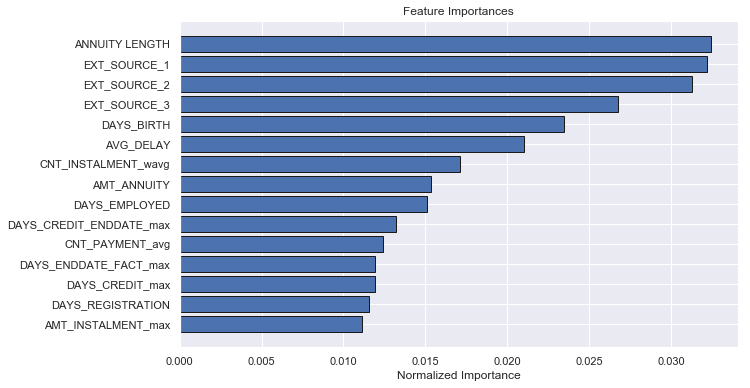

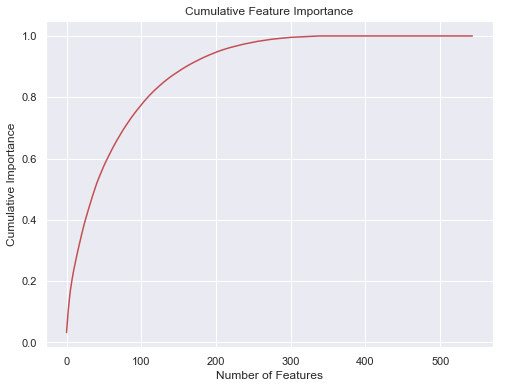

161 features required for 0.90 of cumulative importance


In [141]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [142]:
train_ivs_2 = train_ivs.drop(columns = zero_features)
test_ivs_2 = test_ivs.drop(columns = zero_features)

print('Training shape: ', train_ivs_2.shape)
print('Testing shape: ', test_ivs_2.shape)

Training shape:  (307500, 337)
Testing shape:  (48744, 337)


In [143]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.3, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [144]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train_ivs_2, train_labels)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.781286	valid_0's binary_logloss: 0.50585
Early stopping, best iteration is:
[171]	valid_0's auc: 0.782087	valid_0's binary_logloss: 0.512774
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782343	valid_0's binary_logloss: 0.504827
Early stopping, best iteration is:
[186]	valid_0's auc: 0.782649	valid_0's binary_logloss: 0.508006

There are 15 features with 0.0 importance


In [145]:
train_ivs_3 = train_ivs_2.drop(columns = second_round_zero_features)
test_ivs_3 = test_ivs_2.drop(columns = second_round_zero_features)

print('Training shape: ', train_ivs_3.shape)
print('Testing shape: ', test_ivs_3.shape)

Training shape:  (307500, 322)
Testing shape:  (48744, 322)


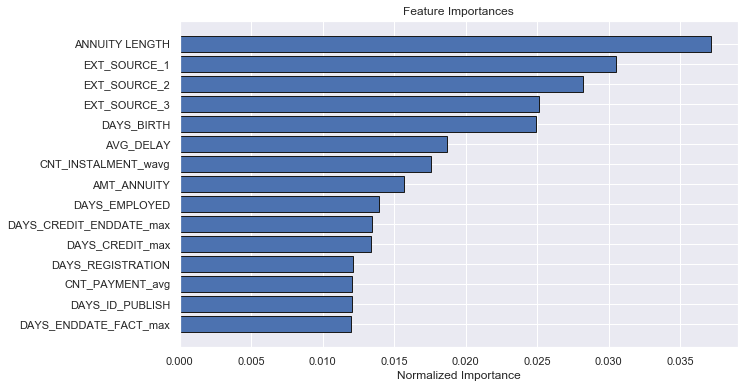

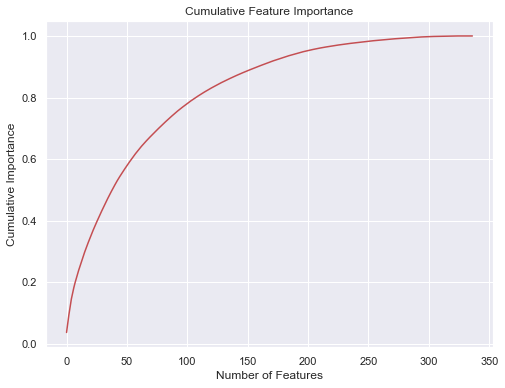

199 features required for 0.95 of cumulative importance


In [146]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [147]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

## 4. modeling & prediction

In [148]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [149]:
def model(features, test_features, encoding = 'ohe', n_folds = 10):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [150]:
train_sub = train[features_to_keep]
train_sub.shape

(307500, 198)

In [152]:
train_sub['TARGET'] = train_labels
train_sub['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [153]:
submission, feature_importances, metrics = model(train_sub, test)
metrics

Training Data Shape:  (307500, 198)
Testing Data Shape:  (48744, 198)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.823999	train's binary_logloss: 0.521445	valid's auc: 0.78313	valid's binary_logloss: 0.537831
[400]	train's auc: 0.858034	train's binary_logloss: 0.482596	valid's auc: 0.784862	valid's binary_logloss: 0.513513
Early stopping, best iteration is:
[320]	train's auc: 0.845721	train's binary_logloss: 0.496862	valid's auc: 0.785257	valid's binary_logloss: 0.521793
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.823629	train's binary_logloss: 0.521533	valid's auc: 0.784494	valid's binary_logloss: 0.540225
[400]	train's auc: 0.85751	train's binary_logloss: 0.482979	valid's auc: 0.787805	valid's binary_logloss: 0.515486
[600]	train's auc: 0.883869	train's binary_logloss: 0.451692	valid's auc: 0.787624	valid's binary_logloss: 0.495482
Early stopping, best iteration is:
[507]	train's auc: 0.872441	train's bina

,fold,train,valid
0,0,0.845721,0.785257
1,1,0.872441,0.788288
2,2,0.878979,0.789910
3,3,0.868248,0.793621
4,4,0.875520,0.784085
5,5,0.877868,0.778783
6,6,0.873324,0.787909
7,7,0.852682,0.788174
8,8,0.857743,0.792787
9,9,0.898460,0.788074


In [154]:
submission.to_csv('selected_features_small_submission_final.csv', index = False)